In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import sys
sys.path.append('../python')
import dataPython as dp
import scipy.interpolate as inter

from datetime import datetime
import scipy.integrate as si
import noordermeer as noord
import NGC5533_functions_newmag as nf
import time

If you do, DISCARD ALL CHANGES TO THE FILE.
Your calculations will NOT be consistent with this library's equations if you use the disk.hdf5 or bulge.hdf5 files,
and if you write to that file it will contain calculations based on conflicting constants.
Worst case scenario, reset the disk.hdf5 file to before the commit where you used this library to write to it.


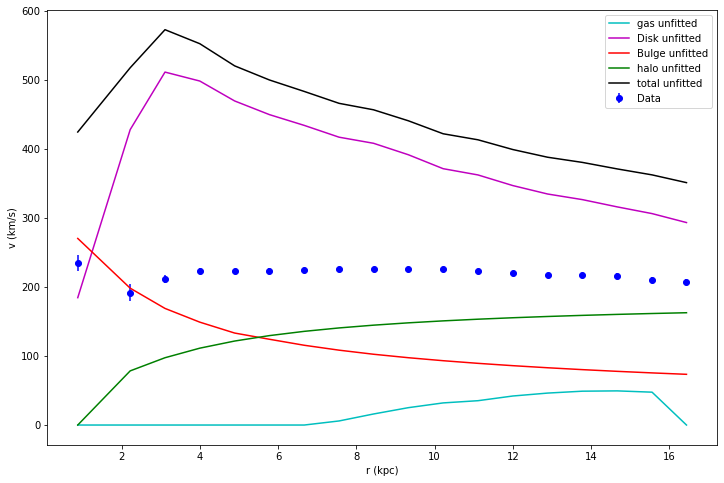

In [2]:
#**********************importing text files******************************
#data:
rc=2.5 #default value
rho00=1e8 #default value

data = dp.getXYdata_wXYerr('891_data')
r = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err1 = np.asarray(data['ey'])
#disk:
disk = dp.getXYZdata('891_thinDiskII')
d = np.asarray(disk['zz'])
#bulge:
bulge = dp.getXYZdata('891_bulge.dat')
b = np.asarray(bulge['zz'])
#gas:
gas = dp.getXYdata('891_thinGas.dat')
g = np.asarray(gas['yy'])

#**********************define total curve******************************
#D=9.25 #disk M-L ratio provided in [1] 
#B=.5 #bulge M-L ratio provided in [1] 
######################################################################################################################
def t(r,B,D,rc,rho00,G):
    return np.sqrt((D*d)**2
                   +(B*b)**2
                   +(nf.h_v(r,rc,rho00))**2
                   +(G*b)**2)

plt.figure(figsize=(12,8))
plt.plot(r,g,'c',label='gas unfitted')
plt.plot(r,d,'m',label='Disk unfitted')
plt.plot(r,b,'r',label='Bulge unfitted') 

plt.plot(r,nf.h_v(r,rc,rho00),'g',label='halo unfitted')
plt.plot(r,t(r,1,1,rc,rho00,1),'k',label='total unfitted')
plt.errorbar(r,v_dat,yerr=v_err1,fmt='bo',label='Data')

plt.xlabel('r (kpc)')
plt.ylabel('v (km/s)')
plt.legend()
plt.show()

In [3]:
v_err1=v_err1
weighdata=1/v_err1
# LMFit

#Setup
g_mod = lm.Model(t)
g_params = g_mod.make_params()

#gas
g_params.add('G', value=1, min=.99,max=1.01)          #Prefactor
#Bulge
g_params.add('B', value=1, min=0)          #Prefactor

#Disk
g_params.add('D', value=1, min=0)       #Prefactor
#Halo
g_params.add('rc', value=rc, min=0)          #Core radius (kpc)
g_params.add('rho00', value=rho00, min=0)     #Central density 

#Do fit
g_fit = g_mod.fit(v_dat,g_params,r=r,weights=weighdata)

In [4]:
# Define for plotting
bestg = g_fit.best_fit
#delg = g_fit.eval_uncertainty()
print('Fit information for all-component fit:')
g_fit

Fit information for all-component fit:


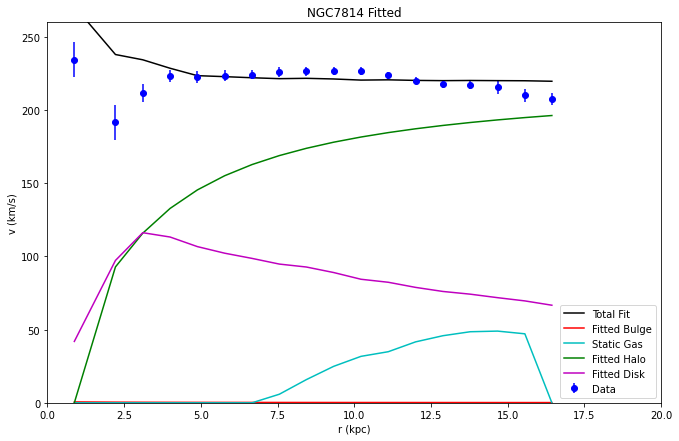

In [5]:
# Define for plotting cont.

#rval = np.linspace(0,11.2,0.1)

g_dict = g_fit.best_values
g_b = g_dict['B']
g_d = g_dict['D']
g_rc = g_dict['rc']
g_rho00 = g_dict['rho00']
g_g = g_dict['G']
halo_curve = nf.h_v(r,g_rc,g_rho00)

plt.figure(figsize=(11,7))
plt.errorbar(r,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r,bestg,'k',label='Total Fit')
plt.plot(r,g_b*b,'r',label='Fitted Bulge')
plt.plot(r,g_g*g,'c',label='Static Gas')
plt.plot(r,halo_curve,'g',label='Fitted Halo')
plt.plot(r,g_d*d,'m',label='Fitted Disk')

plt.legend(loc='lower right')
plt.xlabel('r (kpc)')
plt.ylabel('v (km/s)')
plt.title('NGC7814 Fitted')
plt.ylim([0,260])
plt.xlim([0,20])
plt.show()